## Comparison of atmospheric models used by Bolocalc and Barkats

12/8/2020, JR <br>

<em> TL;DR - Bolocalc and Barkats both (currently) have not-quite-correct atmospheric models, in different ways, that cause a frequency-dependent disagreement between them.  Both should be fixed by using a new set of am models with T0 set to 0.0K, rather than 2.7K, combined with an easy change to Barkats formula for atmospheric power. </em>

Bolocalc and the Barkats NET calculator (hereafter just Barkats) give different optical powers due to atmospheric emission when I try to set them up to use the same South Pole atmospheres. This notebook explores the differences.

There are two separate questions here.
- Are their *am* outputs the same, or nearly the same?
- Do they use those *am* outputs the same, or if not, what are the differences and are they important?

Additionally, Bolocalc changed its South Pole atmosphere file on 9/20/2020, claiming that the treatment for water vapor at the Pole was previously incorrect.  We're going to look at both the old and the new versions, to see how significantly this changed things.

*am* (https://www.cfa.harvard.edu/~spaine/am/) takes an ".amc" file as its input, along with some command line parameters.  I have the .amc files used by Barkats, as well as the respective output files.  Bolocalc stores its *am* output in an hdf5 file, and I do not have the relevant .amc files.

*am* can be configured to write out a variety of values as a function of frequency.  Barkats' output files contain (f, tau, Tx, Trj, Tb),
where the latter four columns are, for each frequency,
- tau is the atmospheric optical depth,
- Tx = exp(-tau) is the tranmission,
- Trj is the Rayleigh-Jeans temperature corresponding the to intensity of the radiation reaching the telescope aperture,
- Tb is the Planck temperature corresponding to the intensity of the radiation reaching the telescope aperture.

Note that *am* assume a blackbody radiation spectrum at temperature T0 entering the atmosphere from above.  If we set T0 = 2.7 (as Barkats has, and as it appears Bolocalc has), the reported Tb and Trj then include the CMB brightness.  If we want just the atmospheric brightness, we should set T0=0.0K before running *am*.

Let's examine first whether they appear to be using consistent *am* output files.



In [1]:
# Define useful functions
c= 2.99792458e8
h = 6.626068e-34
k = 1.3806503e-23
Tcmb = 2.726
n_pol = 1
def Bnu(T,nu):
    x = (h*nu)/(k*T)
    B =  n_pol*(h*nu)*(nu/c)**2 * (1./(np.exp(x) - 1.))
    return B
def Brj(T,nu):
    n_pol = 1
    x = (h*nu)/(k*T)
    B = n_pol*(k*T*nu**2)/(c**2)
    return B
def Tb(T,nu,emiss):
    B = emiss*Bnu(T,nu)
    x = np.log((n_pol*h*nu**3)/(B*c**2) + 1)
    Tb = h*nu/(k*x)
    return Tb
def dBdTcmb(nu):
    # This is for n_pol polarizations.
    x = (h*nu)/(k*Tcmb)
    prefac = n_pol*h**2/(k*c**2)
    expx = np.exp(x)
    dBdT = prefac*(nu**4/Tcmb**2)*(expx/(expx - 1)**2)
    return dBdT
def dPdTcmb(nu):
    # This is for a single-mode detector, AOmega = lambda^2 = (c/nu)^2
    dPdT = dBdTcmb(nu)*(c/nu)**2
    return dPdT


# Compare the Bolocalc and Barkats atmospheres for the same South Pole settings.

Let's plot $T_b$ vs. frequency for three versions of $T_b$, all using a South Pole atmosphere, observing at el = 60deg.
- Bolocalc "original" (pre Sept 2020), 400u pwv
- Bolocalc "new" (post Sept 2020), 400u pwv
- Barkats, 50th percentile, 425u pwv

(In the plots below, the red and blue bands are the dichroic (red=lower, blue=upper) bands of CMB-S4)

In [1]:
import matplotlib.pyplot as plt
import h5py as hp
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [10, 8]

bc_root_dir = "/Users/ruhl/code/BoloCalc/"

# read in original atm file
atmfile_orig = bc_root_dir + "../atm_origJR.hdf5"
hf_orig = hp.File(atmfile_orig, "r")
bcalc_atm_orig=hf_orig["Pole"]["400,60"] # first number is PWV, second is observing elevation.

# read in new atm file
atmfile_new = bc_root_dir + "src/mv_atm_20200916.hdf5"
hf_new = hp.File(atmfile_new, "r")
bcalc_atm_new=hf_new["Pole"]["400,60"] # first number is PWV, second is observing elevation.

# Barkat's code version
# output f GHz  tau neper  tx none  Trj K  Tb K
# f, tau, tx, Trj, Tb
# note that column 5 is Tb, which is what Bolocalc uses.
f,tau,tx,c4,c5 = np.loadtxt('atmos/SPole_annual_50_el60.out',unpack=True)

plt.plot(bcalc_atm_orig[0],bcalc_atm_orig[2],label='Bolocalc orig, 400u, el=60')
plt.plot(bcalc_atm_new[0],bcalc_atm_new[2],label='Bolocalc new, 400u, el=60')
plt.plot(f,c5,label='Barkats, 425u, el=60')

plt.plot(bcalc_atm_orig[2]-bcalc_atm_new[2])

plt.xlabel("Frequency (GHz)")
plt.ylabel('T_b')
plt.xlim([0,350])
plt.ylim([0,60])
plt.title('South Pole, Tb (Planck Brightness temperature)')
plt.legend(loc='upper left')
plt.grid()

# make colored bands for CMB-S4's frequency bands
f_center_vec = np.array([30.0,40.0,95.0,150.0,220.,280.])
fill_color_vec = ['red','blue','red','blue','red','blue']
frac_bw = 0.24
for iii in range(f_center_vec.size):
    f_low = f_center_vec[iii]*(1.-frac_bw/2.)
    f_high = f_center_vec[iii]*(1.+frac_bw/2.)
    plt.axvspan(f_low,f_high,alpha=0.2, color=fill_color_vec[iii])

OSError: Unable to open file (unable to open file: name = '/Users/ruhl/code/BoloCalc/../atm_origJR.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

This tells us that the Tb's output by these files are very consistent, so it appears we're in very good shape on that front.

# Using these *am* spectra
Note though that Barkats' .amc files have set T0=2.7K, which means that the $T_b$ reported by *am* is not just due to the atmosphere - it includes the CMB.

Barkats gets around this potential bias by calculating the in-band optical power by setting the atmospheric Planck brightness temperature to <br>
$$ T_b = 250 * (1 - t_x) $$ <br>
where $t_x$ is the total transmission of the atmosphere, which he assumes is at a physical temperature of 250K.  That is, he ignores the $T_b$ reported by *am*, and replaces it with the value given above.  This is only a rough approximation because the "average" physical temperature of the atmosphere is not exactly 250K - that's just a guess.

Given that the *am* $T_b$ outputs agree as shown above,
this issue points to a possible problem in Bolocalc, if it has assumed the *am* output is the atmospheric brightness only.

# *am* with and without the CMB
Motivated by the issues discussed above, I ran *am* with one of Barkats' .amc files as an input (South Pole, 50th percentile pwv=425u, setting el=60), both with T0=2.7K and T0=0.0K, to see the effect on the Planck $T_b$ as a function of frequency.  As shown in the plot below, the effect is substantial at low frequencies, ie in the 20, 30, 40GHz bands.

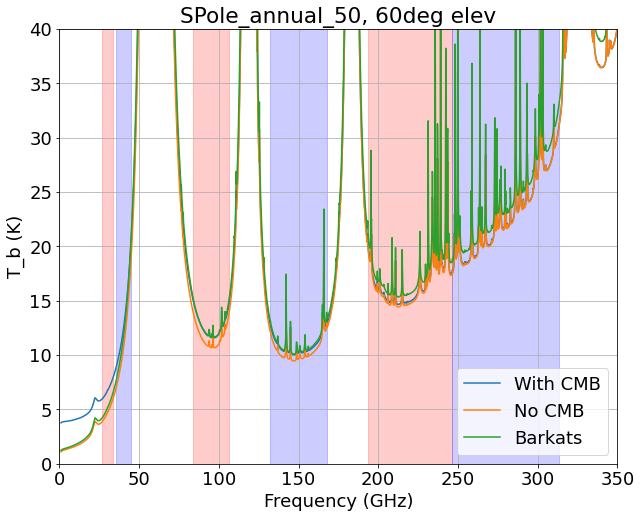

In [3]:
# Using Barkats' SPole_annual_50_nocmb.amc
# only changing T0 parameter to (0, 2.7)K for these two runs.
f0,tau0,tx0,Trj0,Tb0 = np.loadtxt('/Users/ruhl/code/Barkats_NET_forecast/am_spectra/JRruns/SPole_annual_50_withcmb.out',unpack=True)
f1,tau1,tx1,Trj1,Tb1 = np.loadtxt('/Users/ruhl/code/Barkats_NET_forecast/am_spectra/JRruns/SPole_annual_50_nocmb.out',unpack=True)

plt.plot(f0,Tb0,label='With CMB')
plt.plot(f1,Tb1,label='No CMB')
T_barkats = Tb(250,f0*1e9,(1-tx0))  #Find the Tb that corresponds to emiss*Bnu(250K)
plt.plot(f0,T_barkats,label='Barkats')
#plt.plot(f,c5)
plt.xlabel('Frequency (GHz)')
plt.ylabel('T_b (K)')
plt.legend()
plt.title('SPole_annual_50, 60deg elev')

ymax = 40
plt.ylim(0,ymax)
plt.xlim(0,350)
plt.grid()


#fig, ax = plt.subplots()
#ax.plot(range(20))
#ax.axvspan(8, 14, alpha=0.5, color='red')

f_center_vec = np.array([30.0,40.0,95.0,150.0,220.,280.])
fill_color_vec = ['red','blue','red','blue','red','blue']
frac_bw = 0.24
for iii in range(f_center_vec.size):
    f_low = f_center_vec[iii]*(1.-frac_bw/2.)
    f_high = f_center_vec[iii]*(1.+frac_bw/2.)
    plt.axvspan(f_low,f_high,alpha=0.2, color=fill_color_vec[iii])


# Calculating atmospheric optical power using three prescriptions.
We can calculate the atmospheric optical power (for a single mode, single polarization, tophat band, with known optical efficiency) by integrating over tophat bands using three different prescriptions:
- Using T_b from the "bad" *am* model, ie with T0 = 2.7K
- Using T_b from the "good" *am* model, ie with T0 = 0.0K
- Using Barkats prescription, T_b = 250K, but the power is then multiplied by (1-Tx), where Tx is the atmospheric transmission from *am*.

We can then compare our results with the atmospheric power on the bolometer as calculated by the Bolocalc and Barkats code.  I'm running these with an instrument definition that has an optical efficiency (from detector through the window, to the atmosphere) of 0.308.

We also use a fraction bandwidth of 0.24, centered on nominal CMB-S4 band centers.

In [4]:
#bolocalc optical powers, at (30, 40, 95, 150, 220, 280) GHz
Det_opt_eff_bolocalc = np.array([.389, .417, .404, .400, .402, .399])

Popt_atmos_bolocalc= 1e-12*np.array([0.187, 0.503, 1.024, 1.166, 2.655, 4.848])
#Popt_atmos_bolocalc = (0.400/Det_opt_eff_bolocalc)*Popt_atmos_bolocalc
#Popt_tot_bolocalc = 1e-12*np.array([0.543,0.965,2.011,2.614,4.672,7.273])


#Barkats optical powers, at those same freqs
Popt_atmos_barkats = 1e-12*np.array([0.139, 0.468, 1.033, 1.232, 2.967, 5.441  ])
#Popt_tot_barkats = 1e-12*np.array([0.529, 0.964, 2.057, 2.714, 4.988, 7.913])

#new_bolocalc_eff = 0.4*Popt_tot_barkats/Popt_tot_bolocalc
#print('Set bolocalc detector efficiency to:')
#print(new_bolocalc_eff)


Center freq: 30.0 GHz
  Using right am : 0.124 pW
  Using wrong am : 0.186 pW
  Using Barkats  : 0.138 pW
  dPdTcmb :  3.011e-14 W/K
Center freq: 40.0 GHz
  Using right am : 0.418 pW
  Using wrong am : 0.490 pW
  Using Barkats  : 0.465 pW
  dPdTcmb :  3.942e-14 W/K
Center freq: 95.0 GHz
  Using right am : 0.930 pW
  Using wrong am : 1.026 pW
  Using Barkats  : 1.038 pW
  dPdTcmb :  7.766e-14 W/K
Center freq: 150.0 GHz
  Using right am : 1.120 pW
  Using wrong am : 1.200 pW
  Using Barkats  : 1.247 pW
  dPdTcmb :  8.889e-14 W/K
Center freq: 220.0 GHz
  Using right am : 2.702 pW
  Using wrong am : 2.749 pW
  Using Barkats  : 3.028 pW
  dPdTcmb :  7.400e-14 W/K
Center freq: 280.0 GHz
  Using right am : 4.964 pW
  Using wrong am : 4.989 pW
  Using Barkats  : 5.591 pW
  dPdTcmb :  5.217e-14 W/K


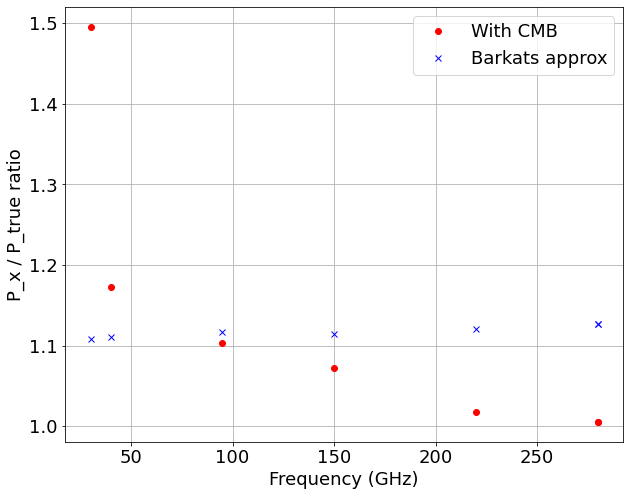

In [5]:
f_center_vec = np.array([30.0,40.0,95.0,150.0,220.,280.])
frac_bw = 0.24
opt_eff = 0.308
bbb = 0
for f_center in f_center_vec:
    f_low = f_center*(1.-frac_bw/2.)
    f_high = f_center*(1.+frac_bw/2.)
    
    # find array indices that correspond to this band
    ii = np.where(np.logical_and(f1>=f_low, f1<=f_high))
    nu = f1[ii]*1e9
    trans = tx0[ii]

    # Single mode, single polarization powers
    P0_atmos    = (c**2/nu**2)*Bnu(Tb0[ii],nu)*opt_eff
    P1_atmos    = (c**2/nu**2)*Bnu(Tb1[ii],nu)*opt_eff
    P2_atmos    =  (c**2/nu**2)*(1-trans)*Brj(250,nu)*opt_eff
    
    dPdTcmb_vec = dPdTcmb(nu)
    dPdTcmb_avg = 0.31*np.trapz(dPdTcmb_vec,x=nu)

    P0    = np.trapz(P0_atmos,x=nu)  # with cmb
    P1    = np.trapz(P1_atmos,x=nu)  # no cmb
    P2    = np.trapz(P2_atmos,x=nu)  # barkats formula
    
    # Plot ratio of "wrong/right" powers
    plt.plot(f_center,P0/P1,'or')
    plt.plot(f_center,P2/P1,'xb')
    
    # Print 
    print('Center freq: {0:2.1f} GHz'.format(f_center))
    #print('Low edge: {0:2.1f} GHz,   High edge: {1:2.1f} GHz'.format(f_low,f_high))
    print('  Using right am : {0:3.3f} pW'.format(P1*1e12))
    #print('  -')
    print('  Using wrong am : {0:3.3f} pW'.format(P0*1e12))
    #print('  Bolocalc result: {0:3.3f} pW'.format(Popt_atmos_bolocalc[bbb]*1e12))
    #print('  -')
    print('  Using Barkats  : {0:3.3f} pW'.format(P2*1e12))
    #print('  Barkats result : {0:3.3f} pW'.format(Popt_atmos_barkats[bbb]*1e12))
    #
    print('  dPdTcmb :  {0:3.3e} W/K'.format(dPdTcmb_avg))

    bbb = bbb+1 # increment index for printing out bolocalc powers

plt.plot(f_center,P0/P1,'or', label='With CMB')
plt.plot(f_center,P2/P1,'xb', label='Barkats approx')
plt.ylabel('P_x / P_true ratio')
plt.xlabel('Frequency (GHz)')
plt.legend()
plt.grid()

# Conclusion

From this we see that Bolocalc is significantly biased at lower frequencies, and pretty close to correct at 220 and 280GHz.  Barkats is fairly uniformly biased about 10% high, which could be corrected by assuming an atmospheric physical temperature of about 225K rather than 250K.

Because the biases have such different frequency dependence, we will have to individually tune one model (frequency by frequency) to match the other, to get the same $P_{optical}$ before calculating NETs.

Unfortunately, the web-based Barkats calculator doe not have T_atmophere as an input parameter, and Bolocalc does not let us specify our own *am* file.  One way to make this work is to tune the detector efficiency in one model (band by band) until the optical  powers on the detector are the same.  I will take this path in another notebook.

# Update 12/18/2020, new bolocalc *am* file.
Charlie Hill ran a new set of *am* files, with T0=0, so they should no longer include CMB power.  Let's compare those to the old ones, and my T0 = 0 run.

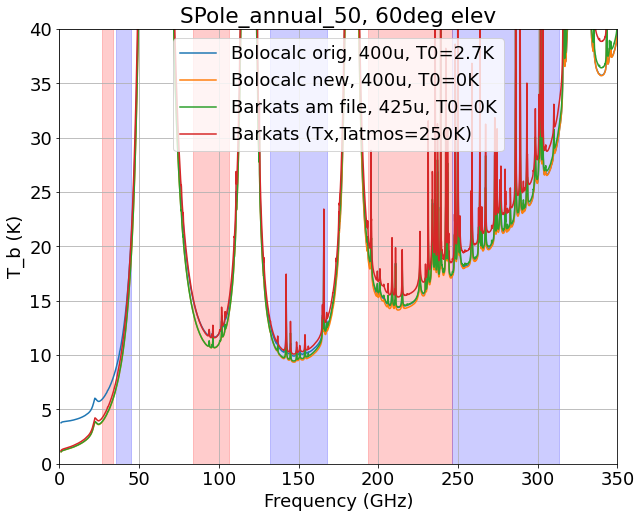

In [13]:
import matplotlib.pyplot as plt
import h5py as hp
%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [10, 8]

bc_root_dir = "/Users/ruhl/code/bolocalc/BoloCalc/"

# read in original atm file
atmfile_orig = bc_root_dir + "../atm_origJR.hdf5"
hf_orig = hp.File(atmfile_orig, "r")
bcalc_atm_orig=hf_orig["Pole"]["400,60"] # first number is PWV, second is observing elevation.

# read in v3 atm file
atmfile_v3 = bc_root_dir + "src/atm_20201217.hdf5"
hf_v3 = hp.File(atmfile_v3, "r")
bcalc_atm_v3=hf_v3["Pole"]["400,60"] # first number is PWV, second is observing elevation.


plt.plot(bcalc_atm_orig[0],bcalc_atm_orig[2],label='Bolocalc orig, 400u, T0=2.7K')
plt.plot(bcalc_atm_v3[0],bcalc_atm_v3[2],label='Bolocalc new, 400u, T0=0K')


# Using Barkats' SPole_annual_50_nocmb.amc
# only changing T0 parameter to (0, 2.7)K for these two runs.
f0,tau0,tx0,Trj0,Tb0 = np.loadtxt('/Users/ruhl/code/Barkats_NET_forecast/am_spectra/JRruns/SPole_annual_50_withcmb.out',unpack=True)
f1,tau1,tx1,Trj1,Tb1 = np.loadtxt('/Users/ruhl/code/Barkats_NET_forecast/am_spectra/JRruns/SPole_annual_50_nocmb.out',unpack=True)

#plt.plot(f0,Tb0,label='With CMB')
plt.plot(f1,Tb1,label='Barkats am file, 425u, T0=0K')
T_barkats = Tb(250,f0*1e9,(1-tx0))  #Find the Tb that corresponds to emiss*Bnu(250K)
plt.plot(f0,T_barkats,label='Barkats (Tx,Tatmos=250K)')
#plt.plot(f,c5)
plt.xlabel('Frequency (GHz)')
plt.ylabel('T_b (K)')
plt.legend()
plt.title('SPole_annual_50, 60deg elev')

ymax = 40
plt.ylim(0,ymax)
plt.xlim(0,350)
plt.grid()


#fig, ax = plt.subplots()
#ax.plot(range(20))
#ax.axvspan(8, 14, alpha=0.5, color='red')

f_center_vec = np.array([30.0,40.0,95.0,150.0,220.,280.])
fill_color_vec = ['red','blue','red','blue','red','blue']
frac_bw = 0.24
for iii in range(f_center_vec.size):
    f_low = f_center_vec[iii]*(1.-frac_bw/2.)
    f_high = f_center_vec[iii]*(1.+frac_bw/2.)
    plt.axvspan(f_low,f_high,alpha=0.2, color=fill_color_vec[iii])



From these we see that the new bolocalc atmosphere files look consistent with the "no cmb" version of *am*.